In [20]:
import pandas as pd
import numpy as np

In [21]:
irl_results = pd.read_excel("optimization_results.xlsx")
bc_results = pd.read_excel("outputs_bc.xlsx")

predictive_processing_dataset = pd.read_excel("RETOS_BEBRASK_long.xlsx")
scales = pd.read_excel("filled_scales_BEBRASK_RETOS.xlsx")
bc_results.drop("Unnamed: 0", axis=1,inplace=True)
irl_results.drop("Unnamed: 0", axis=1,inplace=True)


In [22]:
baseline = pd.read_excel("RETOS_BEBRASK_Baseline.xlsx")
baseline

,Subject,Mean_Rating0,Dif_Match,Cor_Pred_Like
0,PREDWELL_RETOS-1-1,2.888889,1.614379,0.113495
1,PREDWELL_RETOS-10-1,2.533333,1.117647,0.214781
2,PREDWELL_RETOS-1001-1,2.644444,1.494553,0.336312
3,PREDWELL_RETOS-1002-1,2.711111,1.318083,0.450822
4,PREDWELL_RETOS-1003-1,2.200000,1.424837,0.073526
...,...,...,...,...
144,PREDWELL_RETOS-5-1,2.377778,1.300654,0.225374
145,PREDWELL_RETOS-6-1,2.266667,1.152505,0.499722
146,PREDWELL_RETOS-7-1,2.444444,1.352941,0.426911
147,PREDWELL_RETOS-8-1,2.555556,1.117647,0.186173


In [23]:
def clean_and_convert(row):
    numbers = []  # List to store the final numbers
    current_number = ""  # Temporary string to build the current number
    decimal_count = 0  # Counter for decimal places
    in_decimal = False  # State to track if we are currently after a decimal point
    in_exponent = False  # State to check if we are in the exponent part of a number

    for char in row:
        if char.isdigit():
            if in_decimal and decimal_count < 3:
                decimal_count += 1
                current_number += char
            elif not in_decimal or in_exponent:
                current_number += char
        elif char == '.' and not in_decimal and not in_exponent:
            in_decimal = True
            current_number += char
            decimal_count = 0
        elif (char == 'e' or char == 'E') and 'e' not in current_number and 'E' not in current_number:
            in_exponent = True
            current_number += char
        elif (char == '+' or char == '-') and (current_number.endswith('e') or current_number.endswith('E')):
            current_number += char
        else:
            # Finalize the current number when encountering non-numeric/non-decimal/non-exponent characters
            if current_number:
                try:
                    numbers.append(float(current_number))
                except ValueError:
                    pass  # In case the conversion fails, ignore this number
            current_number = ""
            in_decimal = False
            in_exponent = False
            decimal_count = 0

    # Add the last number if there's any leftover after the loop
    if current_number:
        try:
            numbers.append(float(current_number))
        except ValueError:
            pass

    # Convert list to a numpy array
    numbers_array = np.array(numbers)
 
    reshaped_array = numbers_array.reshape(2, 4)
    return reshaped_array
irl_results['best_rewards'] = irl_results['best_rewards'].apply(clean_and_convert)


In [24]:
subject_removal = predictive_processing_dataset["DataFile.Basename"].isin(scales["EPRIME_CODE"])
predictive_processing_dataset = predictive_processing_dataset[subject_removal].reset_index(drop=True)
irl_results = irl_results[subject_removal].reset_index(drop=True)
bc_results = bc_results[subject_removal].reset_index(drop=True)

In [25]:
datafile_basename = predictive_processing_dataset["DataFile.Basename"]
df_to_merge = datafile_basename.to_frame(name='datafile_basename')
merged_df = df_to_merge.merge(scales, left_on='datafile_basename', right_on='EPRIME_CODE', how='left')

# Optionally, drop the EPRIME_CODE column if it's redundant now
merged_df.drop('SUBJECT_CODE', axis=1, inplace=True)

# If you need the 'scales' DataFrame but reordered, you can drop the 'datafile_basename'
reordered_scales = merged_df.drop('datafile_basename', axis=1)

# Display the reordered DataFrame
reordered_scales

,EPRIME_CODE,Age,PA,NA.,ERQ_CR,ERQ_ES,UPPSP_NU,UPPSP_PU,UPPSP_SS,UPPSP_PMD,...,RRQ_Rum,RRQ_Ref,ASI_P,ASI_C,ASI_S,SPQ,SPQ_IR,MSSB_POS,MSSB_NEG,MSSB_DES
0,PREDWELL_RETOS-1-1,19,43,23,6.170000,5.75,9,11,12,5.0,...,3.500000,4.170000,6.0,2.0,23,2,3,1,2,2
1,PREDWELL_RETOS-10-1,22,32,14,4.830000,2.25,6,9,8,7.0,...,1.670000,4.080000,2.0,1.0,4,1,1,0,1,0
2,PREDWELL_RETOS-101-1,25,30,17,6.330000,1.75,8,14,14,12.0,...,3.670000,3.830000,5.0,3.0,11,2,3,2,1,2
3,PREDWELL_RETOS-102-1,20,31,20,4.670000,3.75,7,9,10,5.0,...,3.750000,2.420000,2.0,5.0,12,3,3,3,3,3
4,PREDWELL_RETOS-103-1,32,26,23,5.000000,5.00,8,8,8,6.0,...,3.420000,3.170000,8.0,6.0,15,2,1,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,PREDWELL_RETOS-1124-1,21,33,20,3.666667,3.75,8,9,11,4.0,...,3.833333,2.416667,3.0,5.0,10,4,6,6,4,1
145,PREDWELL_RETOS-1125-1,20,25,22,3.166667,5.75,4,6,9,6.0,...,2.916667,3.583333,0.0,3.0,4,5,6,2,12,4
146,PREDWELL_RETOS-1126-1,18,45,20,4.000000,4.00,11,12,13,9.0,...,2.166667,2.666667,7.0,2.0,6,4,1,1,0,3
147,PREDWELL_RETOS-1127-1,20,35,19,6.666667,2.50,5,10,14,6.0,...,4.333333,2.500000,3.0,4.0,6,7,4,2,0,2


### Analysis of Extracted Features

#### Learning Rate after Match and after NonMatch

array([[<Axes: title={'center': 'beta_no_match'}>,
        <Axes: title={'center': 'beta_match'}>]], dtype=object)

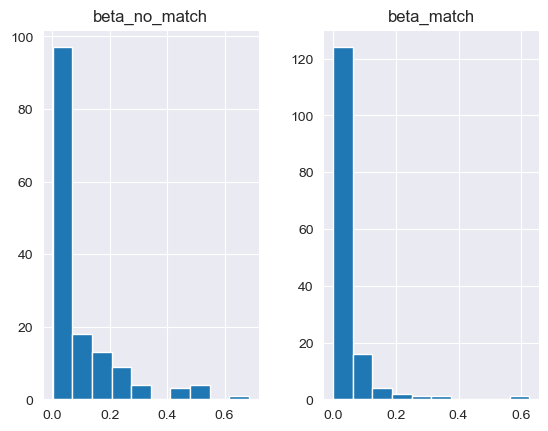

In [26]:
from sklearn.preprocessing import  PowerTransformer

irl_results[['beta_no_match', 'beta_match']].hist()

array([[<Axes: title={'center': 'beta_no_match'}>,
        <Axes: title={'center': 'beta_match'}>]], dtype=object)

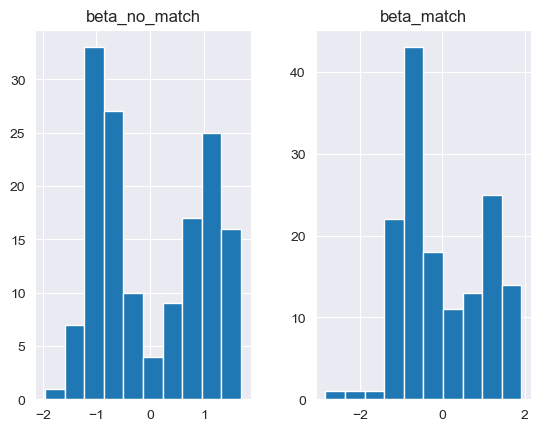

In [27]:
pt = PowerTransformer(method='box-cox', standardize=True)
irl_results_transformed = irl_results.copy()

irl_results_transformed[['beta_no_match', 'beta_match']] = pt.fit_transform(irl_results[['beta_no_match', 'beta_match']] + 1e-6)  # Adding a small
irl_results_transformed[['beta_no_match', 'beta_match']].hist()


In [28]:
from scipy.stats import zscore

skewed_columns = ["UPPSP_PMD", "UPPSP_PSV", "ASI_P", "ASI_C", "MSSB_POS", "MSSB_NEG", "MSSB_DES"]
scales.rename(columns={'NA.': 'NA'}, inplace=True)

scales_transformed = scales.copy()
# Apply Box-Cox transformation to skewed variables
pt = PowerTransformer(method='box-cox', standardize=False)
scales_transformed[skewed_columns] = pt.fit_transform(scales_transformed[skewed_columns] + 1e-6)  # Adding a small
metrics_columns = scales_transformed.drop(["EPRIME_CODE", "SUBJECT_CODE", "Age"], axis=1).columns.values

scales_transformed[metrics_columns] = scales_transformed[metrics_columns].apply(zscore)


In [29]:
scales.rename(columns={'NA.': 'NA'}, inplace=True)


### Normalizing data

In [30]:
irl_results_transformed_rewards = pd.DataFrame(
    irl_results_transformed['best_rewards'].apply(lambda x: x.flatten()).tolist()
)
just_rewards = irl_results_transformed_rewards.copy()

irl_results_transformed_rewards["alpha_match"] = irl_results_transformed["beta_match"]
irl_results_transformed_rewards["alpha_no_match"] = irl_results_transformed["beta_no_match"]
irl_results_transformed_rewards.columns = irl_results_transformed_rewards.columns.astype(str)



In [31]:
from sklearn.preprocessing import StandardScaler

# Load the dataset (mocking the data as no file is provided)
just_rewards.columns = ["rew_0_0","rew_0_1","rew_0_2","rew_0_3","rew_1_0","rew_1_1","rew_1_2","rew_1_3"]

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the 'rewards' column
just_rewards_scaled = scaler.fit_transform(just_rewards)
just_rewards_scaled = pd.DataFrame(just_rewards_scaled, index=just_rewards.index, columns=just_rewards.columns)




In [32]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_results = {}
coefficients = {}
significant_results = []

for metric in metrics_columns:
    # Combine the data
    data = pd.concat([just_rewards_scaled, scales[[metric]]], axis=1)
    
    # Define the model formula
    formula = f'{metric} ~ {" + ".join(just_rewards_scaled.columns)}'
    
    # Fit the model
    model = ols(formula, data=data).fit()
    
    # Perform ANOVA
    anova_result = sm.stats.anova_lm(model, typ=2)
    anova_results[metric] = anova_result
    
    # Store the coefficients
    coefficients[metric] = model.params
    
    # Check if p-value is less than 0.05 for any feature and save the relevant results
    significant = False
    for feature in just_rewards.columns:
        if anova_result.loc[feature, 'PR(>F)'] < 0.05:
            significant = True
            significant_results.append({
                'feature': feature,
                'metric': metric,
                'coefficient': model.params[feature],
                'p_value': anova_result.loc[feature, 'PR(>F)']
            })
    
    # Print the whole ANOVA results if any p-value is lower than 0.05
    if significant:
        print(f"ANOVA Results for metric: {metric}")
        print(anova_result)
        print("\n")

# Convert the significant results to a DataFrame
significant_df = pd.DataFrame(significant_results)
print("Significant Results:")
print(significant_df)


ANOVA Results for metric: PA
               sum_sq     df         F    PR(>F)
rew_0_0     59.749989    1.0  1.466843  0.227885
rew_0_1      1.109604    1.0  0.027240  0.869145
rew_0_2      0.060915    1.0  0.001495  0.969208
rew_0_3     11.781017    1.0  0.289220  0.591575
rew_1_0     29.987723    1.0  0.736189  0.392351
rew_1_1     12.558869    1.0  0.308316  0.579601
rew_1_2     26.943274    1.0  0.661448  0.417430
rew_1_3    189.288257    1.0  4.646964  0.032818
Residual  5702.724224  140.0       NaN       NaN


ANOVA Results for metric: NA
               sum_sq     df         F    PR(>F)
rew_0_0      4.701062    1.0  0.171934  0.679033
rew_0_1      3.456764    1.0  0.126426  0.722702
rew_0_2      1.542231    1.0  0.056405  0.812618
rew_0_3     26.139359    1.0  0.956008  0.329881
rew_1_0      9.549249    1.0  0.349250  0.555491
rew_1_1    159.394015    1.0  5.829599  0.017050
rew_1_2    113.980480    1.0  4.168667  0.043056
rew_1_3      6.446477    1.0  0.235770  0.628037
Residual 

In [43]:
bc_results.columns =  ["rew_0_0_0","rew_0_0_1","rew_0_0_2","rew_0_0_3","rew_1_0_0","rew_1_0_1","rew_1_0_2","rew_1_0_3","rew_0_1_0","rew_0_1_1","rew_0_1_2","rew_0_1_3","rew_1_1_0","rew_1_1_1","rew_1_1_2","rew_1_1_3"]

In [44]:
scaler = StandardScaler()

# Standardize the 'rewards' column
bc_results_scaled = scaler.fit_transform(bc_results)
bc_results_scaled = pd.DataFrame(bc_results_scaled, index=bc_results.index, columns=bc_results.columns)


In [58]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_results = {}
coefficients = {}
significant_results = []

for metric in metrics_columns:
    # Combine the data
    data = pd.concat([bc_results_scaled, scales[[metric]]], axis=1)
    
    # Define the model formula
    formula = f'{metric} ~ {" + ".join(bc_results_scaled.columns)}'
    
    # Fit the model
    model = ols(formula, data=data).fit()
    
    # Perform ANOVA
    anova_result = sm.stats.anova_lm(model, typ=2)
    anova_results[metric] = anova_result
    
    # Store the coefficients
    coefficients[metric] = model.params
    
    # Check if p-value is less than 0.05 for any feature and save the relevant results
    significant = False
    for feature in bc_results_scaled.columns:
        if anova_result.loc[feature, 'PR(>F)'] < 0.05:
            significant = True
            significant_results.append({
                'feature': feature,
                'metric': metric,
                'coefficient': model.params[feature],
                'p_value': anova_result.loc[feature, 'PR(>F)']
            })
    
    # Print the whole ANOVA results if any p-value is lower than 0.05
    if significant:
        print(f"ANOVA Results for metric: {metric}")
        print(anova_result)
        print("\n")

# Convert the significant results to a DataFrame
significant_df = pd.DataFrame(significant_results)
print("Significant Results:")
print(significant_df)


ANOVA Results for metric: ERQ_CR
              sum_sq     df         F    PR(>F)
rew_0_0_0   0.113245    1.0  0.166235  0.684140
rew_0_0_1   0.113244    1.0  0.166235  0.684141
rew_0_0_2   0.113247    1.0  0.166238  0.684137
rew_0_0_3   0.113241    1.0  0.166230  0.684145
rew_1_0_0   4.939618    1.0  7.251018  0.008005
rew_1_0_1   4.939616    1.0  7.251014  0.008005
rew_1_0_2   4.939627    1.0  7.251030  0.008005
rew_1_0_3   4.939599    1.0  7.250990  0.008005
rew_0_1_0   0.200645    1.0  0.294533  0.588245
rew_0_1_1   0.200644    1.0  0.294531  0.588247
rew_0_1_2   0.200646    1.0  0.294534  0.588245
rew_0_1_3   0.200644    1.0  0.294532  0.588246
rew_1_1_0   0.281228    1.0  0.412823  0.521655
rew_1_1_1   0.281225    1.0  0.412818  0.521657
rew_1_1_2   0.281228    1.0  0.412824  0.521654
rew_1_1_3   0.281225    1.0  0.412820  0.521656
Residual   89.922499  132.0       NaN       NaN


ANOVA Results for metric: UPPSP_PSV
               sum_sq     df         F    PR(>F)
rew_0_0_0   51.6

In [56]:
anova_results = {}
coefficients = {}
significant_results = []

for metric in metrics_columns:
    # Combine the data
    data = pd.concat([bc_results_scaled, scales[[metric]]], axis=1)
    
    # Define the model formula
    formula = f'{metric} ~ {" + ".join(bc_results_scaled.columns)}'
    # Fit the model
    model = ols(formula, data=data).fit()
    
        # Perform ANOVA
    anova_result = sm.stats.anova_lm(model, typ=2)
    anova_results[metric] = anova_result
    # Store the coefficients
    coefficients[metric] = model.params
    
    # Check if p-value is less than 0.06 for the feature and save the relevant results
    for feature in bc_results.columns:
        if anova_result.loc[feature, 'PR(>F)'] < 0.05:
            significant_results.append({
                'feature': feature,
                'metric': metric,
                'coefficient': model.params[feature],
                'p_value': anova_result.loc[feature, 'PR(>F)']
            })

significant_df = pd.DataFrame(significant_results)
print("Significant Results:")
print(significant_df)


Significant Results:
      feature     metric   coefficient   p_value
0   rew_1_0_0     ERQ_CR  5.066754e+05  0.008005
1   rew_1_0_1     ERQ_CR  3.286263e+05  0.008005
2   rew_1_0_2     ERQ_CR  2.436159e+05  0.008005
3   rew_1_0_3     ERQ_CR  2.154650e+05  0.008005
4   rew_0_0_0  UPPSP_PSV -1.606215e+06  0.006963
5   rew_0_0_1  UPPSP_PSV -1.035193e+06  0.006963
6   rew_0_0_2  UPPSP_PSV -8.024292e+05  0.006963
7   rew_0_0_3  UPPSP_PSV -7.055701e+05  0.006963
8   rew_1_1_0   MSSB_POS  8.414613e+05  0.003772
9   rew_1_1_1   MSSB_POS  8.176213e+05  0.003772
10  rew_1_1_2   MSSB_POS  9.703187e+05  0.003772
11  rew_1_1_3   MSSB_POS  1.340535e+06  0.003772


In [42]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Initialize dictionaries to store results
anova_results = {}
coefficients = {}
significant_results = []

# Loop through each metric in the metrics_columns list
for metric in metrics_columns:
    for feature in ["alpha_match", "alpha_no_match"]:
        # Combine the data
        data = pd.concat([irl_results_transformed_rewards[feature], scales[[metric]]], axis=1)
        # Define the model formula
        formula = f"{metric} ~ {feature}"
    
        # Fit the model
        model = ols(formula, data=data).fit()
        
        # Perform ANOVA
        anova_result = sm.stats.anova_lm(model, typ=2)
        anova_results[metric] = anova_result
    
        # Store the coefficients
        coefficients[metric] = model.params
        
        
        # Check if p-value is less than 0.06 for the feature and save the relevant results
        if anova_result.loc[feature, 'PR(>F)'] < 0.05:
            significant_results.append({
                'feature': feature,
                'metric': metric,
                'coefficient': model.params[feature],
                'p_value': anova_result.loc[feature, 'PR(>F)']
            })

# Optionally, convert the list of significant results to a DataFrame for easier handling
significant_df = pd.DataFrame(significant_results)

# You can now save this DataFrame to a CSV or print it
print("Significant Results:")
print(significant_df)


Significant Results:
          feature   metric  coefficient   p_value
0  alpha_no_match  RRQ_Rum     0.147396  0.021518
1  alpha_no_match  RRQ_Ref     0.200430  0.005237


In [37]:
from sklearn.preprocessing import StandardScaler
merged_df = df_to_merge.merge(baseline, left_on='datafile_basename', right_on='Subject', how='left')
reordered_baseline = merged_df.drop(['datafile_basename', 'Subject'], axis=1)

scaler = StandardScaler()

reordered_baseline_scaled = scaler.fit_transform(reordered_baseline)
reordered_baseline_scaled = pd.DataFrame(reordered_baseline_scaled, columns=reordered_baseline.columns)

reordered_baseline_scaled

,Mean_Rating0,Dif_Match,Cor_Pred_Like
0,1.993171,0.632545,-0.926969
1,0.502669,-0.852105,-0.534772
2,-0.428894,1.257661,-0.397058
3,0.595826,0.645568,-2.257715
4,-0.615207,0.111615,-0.684158
...,...,...,...
144,-1.360458,-0.773965,-0.376335
145,0.036887,0.951615,0.989496
146,0.875295,0.339522,0.339480
147,0.688982,0.691150,0.089887


In [41]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols



# Initialize dictionaries to store results
anova_results = {}
coefficients = {}
significant_results = []

# Loop through each metric in the metrics_columns list
for metric in metrics_columns:
    for feature in reordered_baseline_scaled.columns:
        # Combine the data
        data = pd.concat([reordered_baseline_scaled[feature], scales[[metric]]], axis=1)

        # Define the model formula
        formula = f"{metric} ~ {feature}"

        # Fit the model
        model = ols(formula, data=data).fit()

        # Perform ANOVA
        anova_result = sm.stats.anova_lm(model, typ=2)
        anova_results[metric] = anova_result

        # Store the coefficients
        coefficients[metric] = model.params

        # Check if p-value is less than 0.06 for the feature and save the relevant results
        if anova_result.loc[feature, 'PR(>F)'] < 0.05:
            significant_results.append({
                'feature': feature,
                'metric': metric,
                'coefficient': model.params[feature],
                'p_value': anova_result.loc[feature, 'PR(>F)']
            })

# Optionally, convert the list of significant results to a DataFrame for easier handling
significant_df = pd.DataFrame(significant_results)

# You can now save this DataFrame to a CSV or print it
print("Significant Results:")
print(significant_df)



Significant Results:
         feature  metric  coefficient   p_value
0   Mean_Rating0  ERQ_CR     0.149701  0.039576
1  Cor_Pred_Like     SHS    -0.109736  0.047351
2      Dif_Match   ASI_C    -0.716183  0.033258


## BC Results

### Random Forest Regressor

In [39]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Define the independent variables (matrix elements)
X = bc_results
X.columns = X.columns.astype(str)
train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the Random Forest model
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = rf.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = rf.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')


Average Training RMSE: 0.510560301368013
Average Test RMSE: 1.0647204065104234


In [40]:
import xgboost as xgb


X = bc_results
X.columns = X.columns.astype(str)
train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 100,
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the XGBoost model
    xgbr = xgb.XGBRegressor(**params)
    xgbr.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = xgbr.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = xgbr.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')


Average Training RMSE: 0.5814181456508993
Average Test RMSE: 1.0549101545998119


## IRL Results

In [ ]:
flattened_best_rewards = pd.DataFrame(
    irl_results['best_rewards'].apply(lambda x: x.flatten()).tolist()
)
flattened_best_rewards["beta_match"] = irl_results["beta_match"]
flattened_best_rewards["beta_no_match"] = irl_results["beta_no_match"]
flattened_best_rewards.columns = flattened_best_rewards.columns.astype(str)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Define the independent variables (matrix elements)
X = flattened_best_rewards
X.columns = X.columns.astype(str)
train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the Random Forest model
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = rf.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = rf.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')
    

#### XGBoost Regressor

In [ ]:
import xgboost as xgb


X = flattened_best_rewards
X.columns = X.columns.astype(str)

train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 100,
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the XGBoost model
    xgbr = xgb.XGBRegressor(**params)
    xgbr.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = xgbr.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = xgbr.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')


### Theory Driven Results

#### Random Forest

In [ ]:
merged_df = df_to_merge.merge(baseline, left_on='datafile_basename', right_on='Subject', how='left')
reordered_baseline = merged_df.drop(['datafile_basename', 'Subject'], axis=1)


In [ ]:
merged_df = df_to_merge.merge(baseline, left_on='datafile_basename', right_on='Subject', how='left')
reordered_baseline = merged_df.drop(['datafile_basename', 'Subject'], axis=1)

X = reordered_baseline
X.columns = reordered_baseline.columns.astype(str)
train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the Random Forest model
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = rf.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = rf.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')



XGBoost

In [ ]:


X = reordered_baseline
X.columns = X.columns.astype(str)  # Ensure all column names are strings

train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 100,
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the XGBoost model
    xgbr = xgb.XGBRegressor(**params)
    xgbr.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = xgbr.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = xgbr.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')


### Mean

In [ ]:
X = reordered_baseline
X.columns = X.columns.astype(str)  # Ensure all column names are strings


baseline_train_rmse_list = []
baseline_test_rmse_list = []


for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Baseline model using the mean
    mean_train_pred = np.full(y_train.shape, y_train.mean())
    mean_test_pred = np.full(y_test.shape, y_train.mean())  # Use the training mean for the test set
    
    baseline_train_rmse = np.sqrt(mean_squared_error(y_train, mean_train_pred))
    baseline_test_rmse = np.sqrt(mean_squared_error(y_test, mean_test_pred))
    
    baseline_train_rmse_list.append(baseline_train_rmse)
    baseline_test_rmse_list.append(baseline_test_rmse)
    

# Calculate the average RMSE for the baseline and Random Forest models
average_baseline_train_rmse = np.mean(baseline_train_rmse_list)
average_baseline_test_rmse = np.mean(baseline_test_rmse_list)

print(f'Average Baseline Training RMSE: {average_baseline_train_rmse}')
print(f'Average Baseline Test RMSE: {average_baseline_test_rmse}')


#### All combined

In [ ]:
flattened_best_rewards.columns = ["a","b","c","d","e","f","g","h","beta_match","beta_no_match"]

X = pd.concat([reordered_baseline,flattened_best_rewards,bc_results],axis=1)
X.columns = X.columns.astype(str) 
train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the Random Forest model
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = rf.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = rf.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')

In [ ]:

X.columns = X.columns.astype(str)  # Ensure all column names are strings

train_rmse_list = []
test_rmse_list = []

params = {
    'n_estimators': 100,
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 42
}

for metric in metrics_columns:
    y = scales_transformed[metric]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the XGBoost model
    xgbr = xgb.XGBRegressor(**params)
    xgbr.fit(X_train, y_train)
    
    # Predict and evaluate on the training set
    y_train_pred = xgbr.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse_list.append(train_rmse)
    
    # Predict and evaluate on the test set
    y_test_pred = xgbr.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse_list.append(test_rmse)

# Calculate the average RMSE
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)

print(f'Average Training RMSE: {average_train_rmse}')
print(f'Average Test RMSE: {average_test_rmse}')
